In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from metrics import MCC

In [2]:
# Model name used to save the weights in h5 format.
# Because I will applied progressive resizing, I will create a total of three different models.
# Check the image_analisys notebook to see the image size distribution

MODEL_NAME_100 = 'malaria_model_100'
#MODEL_NAME_115 = 'malaria_model_115'
MODEL_NAME_130 = 'malaria_model_130'
#MODEL_NAME_145 = 'malaria_model_145'
MODEL_NAME_160 = 'malaria_model_160'


In [3]:
# DATA PATHS

TRAIN_FOLDER_PATH = '../../data/train/'
VAL_FODLER_PATH = '../../data/validation/'
#TEST_FOLDER_PATH = '../../data/test/'
TEST_FOLDER_PATH = '../../data/test_manual'
PREVIEW_IMAGES_FOLDER = '../../data/preview/'

#PREDICTION_FILE_PATH = '../../data/' + MODEL_NAME + '.csv'

In [4]:
# Configure initial hyperparameters
#img_width = 100
#img_height = 100
img_depth = 3

classes = 2
batch_size = 64
num_epochs = 5
loss = "categorical_crossentropy"
learning_rate = 1e-1
decay = 1e-1
momentum = 0.9

In [5]:
# MODEL TRAINING CONFIGURATION

train_datagen = ImageDataGenerator(
    rescale=1 / 255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

def get_train_generator(img_height, img_width):
    train_generator = train_datagen.flow_from_directory(
        TRAIN_FOLDER_PATH,
        target_size = (img_height,img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    return train_generator

def get_validation_generator(img_height, img_width):
    validation_generator = validation_datagen.flow_from_directory(
        VAL_FODLER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return validation_generator

def get_test_generator(img_height, img_width):
    test_generator = test_datagen.flow_from_directory(
        TEST_FOLDER_PATH,
        target_size = (img_height, img_width),
        color_mode='rgb',
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    
    return test_generator

In [6]:
# Callbacks
def get_callbacks(model_name):    
    mc = ModelCheckpoint('best_' + model_name + '.h5', monitor='val_MCC', mode='max', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor = 'val_MCC', patience=10, verbose=1, mode='max')
    reduce_lr = ReduceLROnPlateau(patience=2)
    
    return [mc, es, reduce_lr]

In [7]:
# Plot accuracy and loss values
def plot_metrics(history):
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    #plt.show()
    # summarize history for loss
    plt.subplot(2,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    # Plot MCC values
    plt.subplot(2,2,3)
    plt.plot(history.history['MCC'])
    plt.plot(history.history['val_MCC'])
    plt.title('model MCC')
    plt.ylabel('MCC')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

In [8]:
# Model architecture for the first size
   
img_width = 65
img_height = 65

model_100 = Sequential()

model_100.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_100.add(Activation("relu"))
model_100.add(MaxPooling2D(pool_size=(2,2)))
model_100.add(Dropout(0.25))
model_100.add(BatchNormalization())

model_100.add(Conv2D(64, (3, 3), padding="same"))
model_100.add(Activation("relu"))
#model_100.add(BatchNormalization())
model_100.add(Conv2D(64, (3, 3), padding="same"))
model_100.add(Activation("relu"))

model_100.add(MaxPooling2D(pool_size=(2, 2)))
model_100.add(Dropout(0.25))
model_100.add(BatchNormalization())

model_100.add(Conv2D(128, (3, 3), padding="same"))
model_100.add(Activation("relu"))
#model_100.add(BatchNormalization())
model_100.add(Conv2D(128, (3, 3), padding="same"))
model_100.add(Activation("relu"))
#model_100.add(BatchNormalization())
model_100.add(Conv2D(128, (3, 3), padding="same"))
model_100.add(Activation("relu"))

#model_100.add(MaxPooling2D(pool_size=(2, 2)))
#model_100.add(Dropout(0.25))
#model_100.add(BatchNormalization())

#model_100.add(Flatten())
model_100.add(GlobalAveragePooling2D())
#model_100.add(Dense(256))
#model_100.add(Activation("relu"))
#model_100.add(BatchNormalization())
#model_100.add(Dropout(0.5))

model_100.add(Dense(classes))
model_100.add(Activation("softmax"))

model_100.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 65, 65, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 65, 65, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [9]:
# Compile the model
opt = SGD(lr=learning_rate, momentum=momentum, decay=decay / num_epochs)

model_100.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [10]:
# Fit the model

train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)

history = model_100.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = False,
    workers=1,
    callbacks = get_callbacks(MODEL_NAME_100)
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Epoch 1/5


W0618 17:38:44.117869 140419871450944 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


321/322 [============================>.] - ETA: 0s - loss: 0.6409 - accuracy: 0.6405 - MCC: 0.2810
Epoch 00001: val_MCC improved from -inf to 0.31395, saving model to best_malaria_model_100.h5
322/322 [==============================] - 38s 118ms/step - loss: 0.6410 - accuracy: 0.6402 - MCC: 0.2804 - val_loss: 0.6452 - val_accuracy: 0.6570 - val_MCC: 0.3140
Epoch 2/5
321/322 [============================>.] - ETA: 0s - loss: 0.2888 - accuracy: 0.8844 - MCC: 0.7687
Epoch 00002: val_MCC improved from 0.31395 to 0.77398, saving model to best_malaria_model_100.h5
322/322 [==============================] - 31s 95ms/step - loss: 0.2885 - accuracy: 0.8845 - MCC: 0.7689 - val_loss: 0.2867 - val_accuracy: 0.8870 - val_MCC: 0.7740
Epoch 3/5
321/322 [============================>.] - ETA: 0s - loss: 0.1789 - accuracy: 0.9395 - MCC: 0.8791
Epoch 00003: val_MCC improved from 0.77398 to 0.83503, saving model to best_malaria_model_100.h5
322/322 [==============================] - 31s 95ms/step - loss:

In [11]:
# Save model
model_100.save(MODEL_NAME_100 + '.h5')

In [12]:
# Evaluate the model
model_100.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[0.20634148573113043, 0.9117006, 0.82340115]

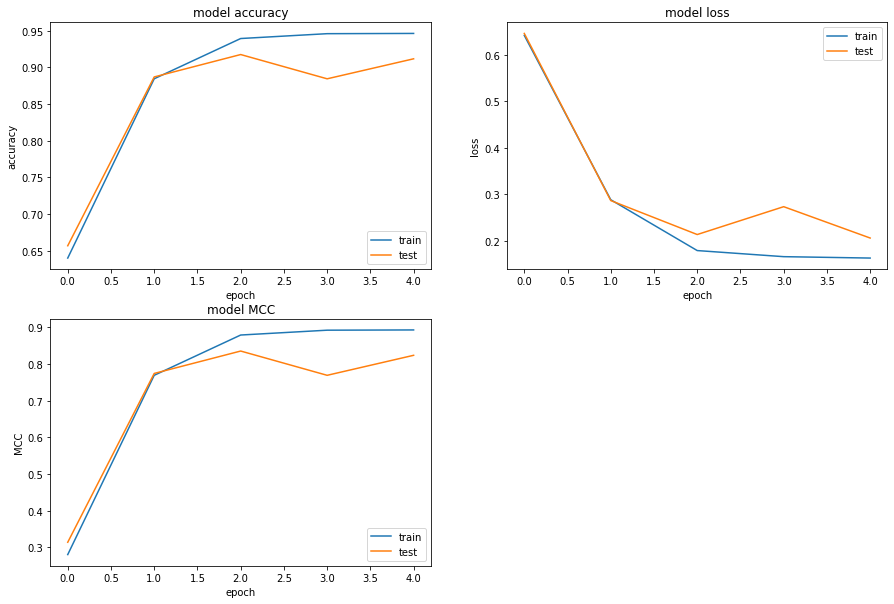

In [13]:
plot_metrics(history)

In [15]:
# Create a new model for the next size and train
img_height = 130
img_width = 130

model_130 = Sequential()
model_130.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_130.add(Activation("relu"))
model_130.add(MaxPooling2D(pool_size=(2,2)))
model_130.add(Dropout(0.25))
model_130.add(BatchNormalization())

# Load the pretrained model
prior = load_model('malaria_model_100.h5', custom_objects={'MCC': MCC})

#for i, layer in enumerate(model_130.layers):
#    print(i, layer.name, layer.input_shape, layer.output_shape)

#for i, layer in enumerate(prior.layers[3:]):
#    print(i, layer.name, layer.input_shape, layer.output_shape)
    
for layer in prior.layers[3:]:
    layer.trainable = False
    model_130.add(layer)

#for layer in prior.layers[-3:]:
    #print(layer.name, layer.trainable)
#    layer.trainable = True
#    model_130.add(layer)
    
#for layer in model_130.layers:
#    print(layer.name, layer.input_shape, layer.output_shape, layer.trainable)

model_130.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 130, 130, 32)      896       
_________________________________________________________________
activation_8 (Activation)    (None, 130, 130, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 65, 65, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 65, 65, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 65, 65, 32)        128       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                 

In [16]:
model_130.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [17]:
train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)

history = model_130.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = False,
    workers=1,
    callbacks = get_callbacks(MODEL_NAME_130)
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Epoch 1/5
321/322 [============================>.] - ETA: 0s - loss: 0.5052 - accuracy: 0.7627 - MCC: 0.5254
Epoch 00001: val_MCC improved from -inf to 0.00109, saving model to best_malaria_model_130.h5
322/322 [==============================] - 61s 190ms/step - loss: 0.5049 - accuracy: 0.7630 - MCC: 0.5260 - val_loss: 6.8855 - val_accuracy: 0.5005 - val_MCC: 0.0011
Epoch 2/5
321/322 [============================>.] - ETA: 0s - loss: 0.3077 - accuracy: 0.9041 - MCC: 0.8083
Epoch 00002: val_MCC improved from 0.00109 to 0.87573, saving model to best_malaria_model_130.h5
322/322 [==============================] - 60s 188ms/step - loss: 0.3075 - accuracy: 0.9043 - MCC: 0.8087 - val_loss: 0.7332 - val_accuracy: 0.9379 - val_MCC: 0.8757
Epoch 3/5
321/322 [============================>.] - ETA: 0s - loss: 0.2638 - accuracy: 0.9089 - MCC: 0.8178
Epoch 00003: val_MCC did not improve from 0.87573
322/322 [======

In [18]:
# Save model
model_130.save(MODEL_NAME_130 + '.h5')

In [19]:
# Evaluate the last model
model_130.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[0.8035341734283192, 0.93404794, 0.86809593]

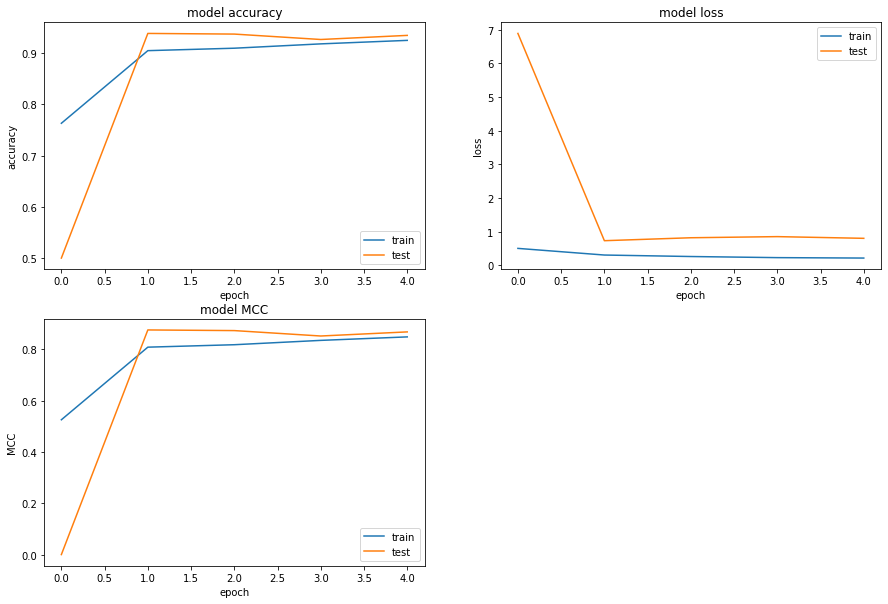

In [20]:
plot_metrics(history)

In [21]:
# Create a new model for the next size and train
img_height = 260
img_width = 260

model_160 = Sequential()
model_160.add(Conv2D(32, (3,3), padding="same", input_shape=(img_width, img_height, img_depth)))
model_160.add(Activation("relu"))
model_160.add(MaxPooling2D(pool_size=(2,2)))
model_160.add(Dropout(0.25))
model_160.add(BatchNormalization())

# Load the pretrained model
prior = load_model('malaria_model_130.h5', custom_objects={'MCC': MCC})
  
for layer in prior.layers[3:]:
    layer.trainable = False
    model_160.add(layer)

model_160.summary()

W0618 17:48:42.567383 140419871450944 hdf5_format.py:192] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 260, 260, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 260, 260, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 130, 130, 32)      0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 130, 130, 32)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 130, 130, 32)      128       
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                 

In [22]:
model_160.compile(loss=loss, optimizer = opt, metrics=["accuracy", MCC])

In [23]:
train_generator = get_train_generator(img_height, img_width)
validation_generator = get_validation_generator(img_height, img_width)

history = model_160.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n // train_generator.batch_size,
    epochs = num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // validation_generator.batch_size,
    use_multiprocessing = False,
    workers=1,
    callbacks = get_callbacks(MODEL_NAME_160)
)

Found 20668 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.
Epoch 1/5
321/322 [============================>.] - ETA: 0s - loss: 0.7789 - accuracy: 0.4919 - MCC: -0.0163
Epoch 00001: val_MCC improved from -inf to 0.03161, saving model to best_malaria_model_160.h5
322/322 [==============================] - 189s 587ms/step - loss: 0.7786 - accuracy: 0.4919 - MCC: -0.0162 - val_loss: 7.0456 - val_accuracy: 0.5158 - val_MCC: 0.0316
Epoch 2/5
321/322 [============================>.] - ETA: 0s - loss: 0.7127 - accuracy: 0.5416 - MCC: 0.0833
Epoch 00002: val_MCC did not improve from 0.03161
322/322 [==============================] - 188s 583ms/step - loss: 0.7127 - accuracy: 0.5414 - MCC: 0.0827 - val_loss: 7.8761 - val_accuracy: 0.5065 - val_MCC: 0.0131
Epoch 3/5
321/322 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5759 - MCC: 0.1518
Epoch 00003: val_MCC improved from 0.03161 to 0.04360, saving model to best_malaria_model_160.h5
322/322 [==

In [24]:
# Save model
model_160.save(MODEL_NAME_160 + '.h5')

In [25]:
# Evaluate the last model
model_160.evaluate_generator(validation_generator, steps = validation_generator.n // validation_generator.batch_size)

[7.493203831273456, 0.5134448, 0.026889535]

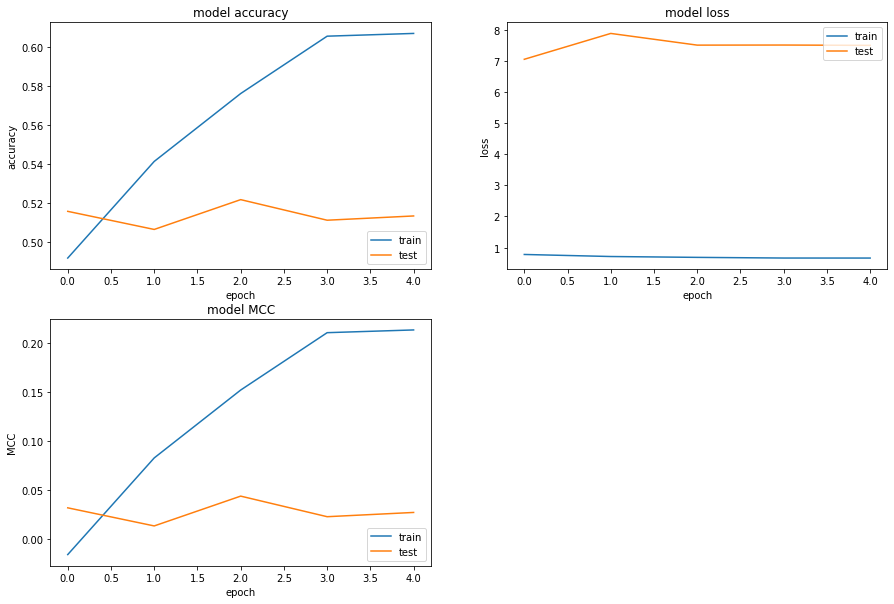

In [26]:
plot_metrics(history)

In [27]:
# Predictions
test_generator = get_test_generator(img_height, img_width)
test_generator.reset()

predIdxs = model_160.predict_generator(test_generator,steps=(test_generator.n // test_generator.batch_size) + 1)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

Found 1376 images belonging to 2 classes.


In [28]:
# Show final metrics
print(classification_report(test_generator.classes, predIdxs, target_names=test_generator.class_indices.keys()))

cm = confusion_matrix(test_generator.classes, predIdxs)
total = sum(sum(cm))
acc = (cm[0,0] + cm[1,1]) / total
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])

print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

 parasitized       0.54      0.28      0.37       688
  uninfected       0.52      0.76      0.62       688

    accuracy                           0.52      1376
   macro avg       0.53      0.52      0.49      1376
weighted avg       0.53      0.52      0.49      1376

acc: 0.5233
sensitivity: 0.2834
specificity: 0.7631
